In [60]:
import requests
from bs4 import BeautifulSoup
import gpxpy
import matplotlib.pyplot as plt

In [5]:
def get_gpx_track(track_number=[]):
    """Send request to la flamme rouge website to a specific gpx track
    
    Parameters
    ------------
    track_number: list of track numbers to parse (int)
        
    Returns
    ------------
    The parsed URLs as a list
    """
    soup = []
    for track in track_number:
        url = 'http://la-flamme-rouge.eu/maps/viewtrack/gpx/'+str(track)
        headers={'User-Agent':'Mozilla/5'}
        r = requests.get(url, allow_redirects=True,headers=headers)
        soup.append(BeautifulSoup(r.text,'html.parser'))
    return soup

def get_elevation(track_html):
    """Extract stage name and elevation information from the text of the parsed URLs
    
    Parameters
    ------------
    track_html: list of parsed URLs
    
    Returns
    ------------
    A dictionary where the key is the stage name and the value is a list [positive_elevation_gain, max_elevation]
    """
    # get elevation from html
    elev_stage = {}
    for track in track_html:
        elev = [int(elev.text) for elev in track.find_all('ele')]
        name = track.find('name').text
        elev_change = sum([elev[i+1]-elev[i] for i in range(len(elev)-1) if elev[i+1]>elev[i]])
        max_elev = max(elev)
        elev_stage[name] = [elev_change, max_elev]
    return elev_stage

In [6]:
%%timeit
track_html = get_gpx_track(track_number=[34572,386318,375307])

9.4 s ± 1.42 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
elev_change= get_elevation(track_html)

NameError: name 'track_html' is not defined

In [ ]:
print(elev_change)

In [17]:
def get_gpx_file(track_number=[]):
    """Send request to la flamme rouge website to a specific gpx track
    saves the gpx file into "/gpx/__track_number__.gpx
    Parameters
    ------------
    track_number: list of track numbers to parse (int)
        
    Returns
    ------------
    void
    """
    for track in track_number:
        url = 'http://la-flamme-rouge.eu/maps/viewtrack/gpx/'+str(track)
        headers={'User-Agent':'Mozilla/5'}
        r = requests.get(url, allow_redirects=True,headers=headers)
        open('gpx/'+str(track)+'.gpx', 'wb').write(r.content)


def get_data_from_gpx(track_number=[]):
    """Extract stage name elevation, max elevation and distance from the text of the files
    
    Parameters
    ------------
    track_number: number of gpx file
    
    Returns
    ------------
    A dictionary where the key is the stage name and the value is a list [positive_elevation_gain, max_elevation, distance]
    """
    data_race={}
    for track in track_number:
        file_name = 'gpx/'+str(track)+'.gpx'
        gpx_file= open(file_name, 'r')
        gpx = gpxpy.parse(gpx_file)
        name = gpx.tracks[0].name
        elev = [point.elevation for point in gpx.tracks[0].segments[0].points]
        elev_change = sum([ elev[i+1] - elev[i] for i in range(len(elev)-1) if elev[i+1] > elev[i] ])
        max_elev = max(elev)
        distance = round(gpx.length_2d()/1000,2)
        data_race[name] = [elev_change, max_elev, distance]

    return [data_race,elev]

In [146]:
get_gpx_file(track_number=[306106])

In [147]:
data=get_data_from_gpx(track_number=[306106])
print(data[0])

{'Tour de France 2020 - Stage 13': [4459.0, 1583.0, 192.11]}


In [159]:
#some functions for the software: get_altitude, get_distance, is_uphill_finish

def get_distance(tracknumber)->float:
    """
    Returns the total distance in km

    Input
    ------------------------- 
    tracknumber (int)

    Output
    -------------------------
    distance (float)
    """
    data = get_data_from_gpx(track_number=[tracknumber])
    return list(data[0].values())[0][2]

def get_altitude(tracknumber, distance=0)->float:
    """
    Returns the altitude of a waypoint, given file name and distance at which you wan to get the altitude
    
    Input
    ------------------------- 
    tracknumber (int) and distance (float, km)

    Output
    -------------------------
    altitude (float, m)
    """
    data = get_data_from_gpx(track_number=[tracknumber])
    waypoint = int( distance * len(data[1]) / list(data[0].values())[0][2])
    return data[1][waypoint-1]

def is_uphill_finish(tracknumber)->bool:
    """
    Determines whether a gpx track can be classified as (uphill finish) UF or not.
    In order to be a UF the criteria that must be met is the following (can be modified)
    -in the last 1.5 km of the race there has to be an average gradient of at least 5%
    -that means at least 75m of elevation

    Input
    ------------------------- 
    tracknumber (int) 

    Output
    -------------------------
    Bool
    """
    finish = get_distance(tracknumber)

    if get_altitude(tracknumber, finish) - get_altitude(tracknumber, finish -1.5) >=75:
        return True
    else:
        return False


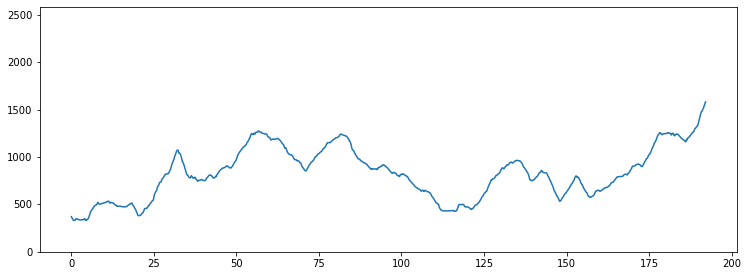

In [165]:
plt.figure(figsize=(12.5, 4.5))
dist = get_distance(306106)
dist_graph =[]
for i in range(len(data[1])):
    dist_graph.append( i/len(data[1]) * dist)
plt.plot(dist_graph, data[1])
plt.ylim(0,max(data[1])+1000)
plt.show()


In [164]:
is_uphill_finish(306106)

True